In [1]:
from importlib.metadata import version

pkgs = [
    "matplotlib", # 그래프 라이브러리
    "numpy", # 파이토치와 텐서플로의 종속성
    "tiktoken", # 토크나이저
    "torch", # 딥러닝 라이브러리
    "tensorflow", # OpenAI의 사전 훈련된 가중치를 위해서
    "pandas", # 데이터셋 로딩을 위해
]
for p in pkgs:
  print(f"{p} 버전: {version(p)}")

matplotlib 버전: 3.10.0
numpy 버전: 2.0.2
tiktoken 버전: 0.12.0
torch 버전: 2.9.0+cu126
tensorflow 버전: 2.19.0
pandas 버전: 2.2.2


In [2]:
import requests
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
  if data_file_path.exists():
    print(f"{data_file_path}가 이미 있어 다운로드 및 압축 해제를 건너뜁니다.")
    return

  # 파일을 다운로드 합니다.
  response = requests.get(url, stream=True, timeout=60)
  response.raise_for_status()
  with open(zip_path, "wb") as out_file:
    for chunk in response.iter_content(chunk_size=8192):
      if chunk:
        out_file.write(chunk)

  # 파일 압축을 푼다.
  with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extracted_path)

  # .tsv 파일 확장자를 추가한다.
  original_file_path = Path(extracted_path) / "SMSSpamCollection"
  os.rename(original_file_path, data_file_path)
  print(f"파일이 다운로드되어 {data_file_path}에 저장되었습니다.")

try:
  download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)
except (requests.exceptions.RequestException, TimeoutError) as e:
  print(f"기본 URL 실패: {e}. 백업 URL을 시도한다...")
  url = "https://f001.backblazeb2.com/file/LLMS-from-scratch/sms%2Bspam%2Bcollection.zip"
  download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

# 책과 방식 다름 책 코드는 책 참고.
# urllib.request는 VPN을 사용할 경우 문제를 일으킬 수 있다.

파일이 다운로드되어 sms_spam_collection/SMSSpamCollection.tsv에 저장되었습니다.


In [3]:
import pandas as pd

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [4]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


In [5]:
def create_balanced_dataset(df):

  # "스팸" 샘플 개수 세기
  num_spam = df[df["Label"] == "spam"].shape[0]

  # "스팸" 샘플 개수와 일치하도록 "햄" 샘플을 무작위로 샘플링
  ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)

  # "햄"과 "스팸"을 합친다.
  balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])

  return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [6]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

In [7]:
balanced_df

,Label,Text
4307,0,Awww dat is sweet! We can think of something t...
4138,0,Just got to &lt;#&gt;
4831,0,"The word ""Checkmate"" in chess comes from the P..."
4461,0,This is wishing you a great day. Moji told me ...
5440,0,Thank you. do you generally date the brothas?
...,...,...
5537,1,Want explicit SEX in 30 secs? Ring 02073162414...
5540,1,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,1,Had your contract mobile 11 Mnths? Latest Moto...
5566,1,REMINDER FROM O2: To get 2.50 pounds free call...


In [20]:
def random_split(df, train_frac, validation_frac):
  # 데이터 프레임 전체 섞기
  df = df.sample(frac=1, random_state=123).reset_index(drop=True)

  # 분할 인덱스 계산
  train_end = int(len(df) * train_frac)
  validation_end = train_end + int(len(df) * validation_frac)

  # 데이터 프레임 분할
  train_df = df[:train_end]
  validation_df = df[train_end:validation_end]
  test_df = df[validation_end:]

  return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)
# 테스트는 나머지 0.2

train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

In [9]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [41]:
import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        # 텍스트 토큰화
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            # max_length보다 긴 시퀀스 자르기
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        # 가장 긴 시퀀스에 맞춰 패딩하기
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length
        # 참고: 이 메서드를 구현하는 더 파이썬적인 버전은
        # 다음과 같으며, 다음 장에서도 사용됩니다.
        # return max(len(encoded_text) for encoded_text in self.encoded_texts)

In [42]:
train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

print(train_dataset.max_length)

120


In [43]:
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

In [44]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

In [46]:
print("훈련 세트 로더:")
for input_batch, target_batch in train_loader:
    pass

print("입력 배치 차원:", input_batch.shape)
print("레이블 배치 차원", target_batch.shape)

훈련 세트 로더:
입력 배치 차원: torch.Size([8, 120])
레이블 배치 차원 torch.Size([8])


In [47]:
print(f"{len(train_loader)}개 훈련 배치")
print(f"{len(val_loader)}개 검증 배치")
print(f"{len(test_loader)}개 테스트 배치")

130개 훈련 배치
19개 검증 배치
38개 테스트 배치


In [49]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,     # 어휘사전 크기
    "context_length": 1024,  # 문맥 길이
    "drop_rate": 0.0,        # 드롭아웃 비율
    "qkv_bias": True         # 쿼리-키-값 편향
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"데이터셋 길이 {train_dataset.max_length}가 모델의 문맥 "
    f"길이 {BASE_CONFIG['context_length']}를 초과합니다. `max_length={BASE_CONFIG['context_length']}`로 "
    f"데이터 셋을 다시 초기화하십시오."
)

In [50]:
!wget https://bit.ly/4jZL2Gr -O gpt_download.py
!wget https://bit.ly/4esl8dj -O previous_chapters.py

--2025-11-23 09:36:04--  https://bit.ly/4jZL2Gr
Resolving bit.ly (bit.ly)... 67.199.248.11, 67.199.248.10
Connecting to bit.ly (bit.ly)|67.199.248.11|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://raw.githubusercontent.com/rickiepark/llm-from-scratch/refs/heads/main/ch06/01_main-chapter-code/gpt_download.py [following]
--2025-11-23 09:36:04--  https://raw.githubusercontent.com/rickiepark/llm-from-scratch/refs/heads/main/ch06/01_main-chapter-code/gpt_download.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6333 (6.2K) [text/plain]
Saving to: ‘gpt_download.py’

gpt_download.py     100%[===================>]   6.18K  --.-KB/s    in 0s      

2025-11-23 09:36:04 (51.7 MB/s) - ‘gpt_download.py’ saved [6333/63

In [51]:
from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 170kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 6.88MiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 221kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [09:17<00:00, 893kiB/s]
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 10.5MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:00<00:00, 3.11MiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 3.68MiB/s]


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

In [52]:
from previous_chapters import (
    generate_text_simple,
    text_to_token_ids,
    token_ids_to_text
)

text_1 = "Every effort moves you"

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


In [53]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


In [54]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

In [55]:
for param in model.parameters():
  param.requires_grad = False

In [56]:
torch.manual_seed(123)

num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

In [57]:
for param in model.trf_blocks[-1].parameters():
  param.requires_grad = True

for param in model.final_norm.parameters():
  param.requires_grad = True

In [58]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("입력:", inputs)
print("입력 차원:", inputs.shape) # shape: (배치 크기, 토큰 수)

입력: tensor([[5211,  345,  423,  640]])
입력 차원: torch.Size([1, 4])


In [59]:
with torch.no_grad():
  outputs = model(inputs)

print("출력:\n", outputs)
print("출력 차원:", outputs.shape) # shape: (배치 크기, 토큰 수, 클래스 수)

출력:
 tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
출력 차원: torch.Size([1, 4, 2])


In [60]:
print("마지막 출력 토큰:", outputs[:, -1, :])

마지막 출력 토큰: tensor([[-3.5983,  3.9902]])


In [61]:
probas = torch.softmax(outputs[:,-1:], dim=-1)
label = torch.argmax(probas)
print("클래스 레이블:", label.item())

클래스 레이블: 1


In [62]:
logits = outputs[:, -1, :]
label = torch.argmax(logits)
print("클래스 레이블:", label.item())

클래스 레이블: 1


In [63]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
  model.eval()
  correct_predictions, num_examples = 0, 0

  if num_batches is None:
    num_batches = len(data_loader)
  else:
    num_batches = min(num_batches, len(data_loader))
  for i, (input_batch, target_batch) in enumerate(data_loader):
    if i < num_batches:
      input_batch, target_batch = input_batch.to(device), target_batch.to(device)

      with torch.no_grad():
        logits = model(input_batch)[:, -1, :] # 마지막 출력 토큰의 로짓
      predicted_labels = torch.argmax(logits, dim=-1)

      num_examples += predicted_labels.shape[0]
      correct_predictions += (predicted_labels == target_batch).sum().item()
    else:
      break
  return correct_predictions / num_examples

In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 참고:
# 다음 줄의 주석 처리를 제거하면 코드가 애플 실리콘 칩에서 실행할 수 있습니다.
# 애플 CPU보다 약 2배 빠릅니다(M3 맥북 에어에서 측정).
# 이 글을 쓰는 시점에서 파이토치 2.4에서는 CPU와 MPS를 통해 얻은 결과가 동일했습니다.
# 그러나 이전 버전의 파이토치에서는 MPS를 사용할 때 다른 결과가 나타날 수 있습니다.

#if torch.cuda.is_available():
#    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
#else:
#    device = torch.device("cpu")
#print(f"실행 장치: {device}")

model.to(device)

torch.manual_seed(123) # 데이터 로더에서 셔플링하기 때문에 재현성을 위해

train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"훈련 정확도: {train_accuracy*100:.2f}%")
print(f"검증 정확도: {val_accuracy*100:.2f}%")
print(f"테스트 정확도: {test_accuracy*100:.2f}%")

훈련 정확도: 46.25%
검증 정확도: 45.00%
테스트 정확도: 48.75%


In [69]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :]  # 마지막 출력 토큰의 로짓
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

In [70]:
# 5장과 동일
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # num_batches가 데이터 로더의 배치 수를 초과하는 경우
        # 데이터 로더의 총 배치 수와 일치하도록 배치 수를 줄입니다.
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [71]:
with torch.no_grad(): # 효율성을 위해 그레이디언트 추적을 비활성화 한다. 아직 훈련하지 않기 때문
  train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
  val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
  test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"훈련 손실: {train_loss:.3f}")
print(f"검증 손실: {val_loss:.3f}")
print(f"테스트 손실: {test_loss:.3f}")

훈련 손실: 1.937
검증 손실: 2.583
테스트 손실: 2.322


In [72]:
# 5장의 `train_model_simple`과 전체적으로 동일
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    # 손실 및 처리한 샘플 수를 위한 리스트 초기화
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # 메인 학습 루프
    for epoch in range(num_epochs):
        model.train()  # 모델을 훈련 모드로 설정

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # 이전 배치 반복에서 얻은 손실의 그레이디언트 재설정
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # 손실 그레이디언트 계산
            optimizer.step() # 손실 그레이디언트를 사용하여 모델 가중치 업데이트
            examples_seen += input_batch.shape[0] # 새로 추가: 토큰 대신 샘플 추적
            global_step += 1

            # 선택적 평가 단계
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"에포크 {epoch+1} (Step {global_step:06d}): "
                      f"훈련 손실 {train_loss:.3f}, 검증 손실 {val_loss:.3f}")

        # 각 에포크 후 정확도 계산
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"훈련 정확도: {train_accuracy*100:.2f}% | ", end="")
        print(f"검증 정확도: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [73]:
# 5장과 동일
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [75]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device, num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"훈련 소요 시간: {execution_time_minutes:.2f}분")

에포크 1 (Step 000000): 훈련 손실 1.977, 검증 손실 2.196
에포크 1 (Step 000050): 훈련 손실 0.615, 검증 손실 0.636
에포크 1 (Step 000100): 훈련 손실 0.520, 검증 손실 0.555
훈련 정확도: 70.00% | 검증 정확도: 72.50%
에포크 2 (Step 000150): 훈련 손실 0.563, 검증 손실 0.488
에포크 2 (Step 000200): 훈련 손실 0.418, 검증 손실 0.395
에포크 2 (Step 000250): 훈련 손실 0.408, 검증 손실 0.352
훈련 정확도: 82.50% | 검증 정확도: 85.00%
에포크 3 (Step 000300): 훈련 손실 0.330, 검증 손실 0.314
에포크 3 (Step 000350): 훈련 손실 0.278, 검증 손실 0.181
훈련 정확도: 90.00% | 검증 정확도: 92.50%
에포크 4 (Step 000400): 훈련 손실 0.076, 검증 손실 0.131
에포크 4 (Step 000450): 훈련 손실 0.125, 검증 손실 0.099
에포크 4 (Step 000500): 훈련 손실 0.202, 검증 손실 0.102
훈련 정확도: 100.00% | 검증 정확도: 97.50%
에포크 5 (Step 000550): 훈련 손실 0.206, 검증 손실 0.110
에포크 5 (Step 000600): 훈련 손실 0.067, 검증 손실 0.056
훈련 정확도: 100.00% | 검증 정확도: 97.50%
훈련 소요 시간: 50.44분


In [78]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # 훈련 및 검증 손실을 에포크에 따라 그립니다.
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # 처리한 샘플 수를 위해 두 번째 x축을 만듭니다.
    ax2 = ax1.twiny()  # 동일한 y축을 공유하는 두 번째 x축을 만듭니다.
    ax2.plot(examples_seen, train_values, alpha=0)  # 눈금 정렬을 위한 보이지 않는 그래프
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # 공간을 확보하기 위해 레이아웃을 조정합니다.
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

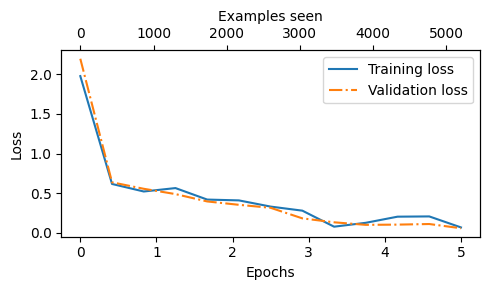

In [79]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)


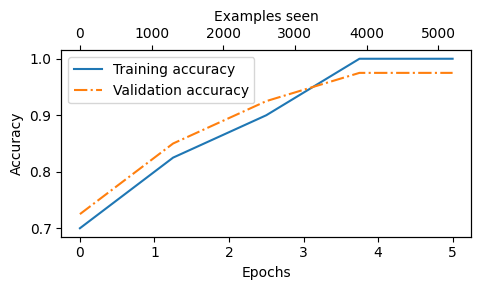

In [80]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

In [81]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"훈련 정확도: {train_accuracy*100:.2f}%")
print(f"검증 정확도: {val_accuracy*100:.2f}%")
print(f"테스트 정확도: {test_accuracy*100:.2f}%")

훈련 정확도: 97.60%
검증 정확도: 97.32%
테스트 정확도: 96.00%


In [84]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    # 모델에 대한 입력 준비
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[0]

    # 너무 긴 시퀀스 자르기
    input_ids = input_ids[:min(max_length, supported_context_length)]
    assert max_length is not None, (
        "max_length가 지정되지 않았습니다. 모델의 최대 문맥 길이를 사용하려면"
        "max_length=model.pos_emb.weight.shape[0]로 지정하세요."
        )
    assert max_length <= supported_context_length, (
        f"max_length({max_length})가 모델이 지원하는 문맥 길이({supported_context_length})를 초과했습니다."
        )

    # 또는 max_length=None인 경우를 안정적으로 처리하는 방법은 다음과 같다.
    # max_len = min(max_length, supported_context_length) if max_length else supported_context_length
    # input_ids = input_ids[:max_len]

    # 가장 긴 시퀀스로 패딩하기
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0) # 배치 차원 추가

    # 모델 추론
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :] # 마지막 출력 토큰의 로짓
    predicted_label = torch.argmax(logits, dim=-1).item()

    # 분류 결과 반환
    return "스팸" if predicted_label == 1 else "스팸아님"


In [85]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

스팸
